In [1]:
"""Use Nick's PPO trained policy to perform inference on whether there is a pedestrian or not"""

import argparse
from datetime import datetime
import gym
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import PyQt5

import ray
try:
    from ray.rllib.agents.agent import get_agent_class
except ImportError:
    from ray.rllib.agents.registry import get_agent_class
from ray.tune.registry import register_env

# from flow.algorithms.maddpg.maddpg import DEFAULT_CONFIG as MADDPG_DEFAULT_CONFIG, MADDPGTrainer


from flow.core.util import emission_to_csv
from flow.utils.registry import make_create_env
from flow.utils.rllib import get_flow_params
from flow.utils.rllib import get_rllib_config
from flow.utils.rllib import get_rllib_pkl

from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_env, create_agent
from examples.rllib.multiagent_exps.bayesian_0_no_grid_env import make_flow_params as bayesian_1_flow_params

EXAMPLE_USAGE = """
example usage:
    python ./visualizer_rllib.py /ray_results/experiment_dir/result_dir 1
Here the arguments are:
1 - the path to the simulation results
2 - the number of the checkpoint
"""

In [2]:
import tensorflow as tf
import ray
import gym

In [3]:
ray.__version__

'0.8.0'

# The Math

$$ p(c|a) = \frac{f(a|c) p(c)}{M}, M = \sum_{e \in every} f(a | e) p(e), c \text{ is some joint ped combination}$$

#### Code flow

e denotes an element within the 'every' set, where 'every' = the set of all possible pedestrian location combinations observable by a vehicle

o denotes an element with the 'other' set, where 'other' = the set of all possible pedestrian location combinations observable by a vehicle, where $o_1 = 1$ or some other specific location has a fixed value.
 
0. Fill up $p(e)$ with $\frac{1}{3^4}$

1. Fill up $f(a|e)$

2. Compute $M = \sum_{e \in every} f(a|e) p(e)$

3. Compute $p(e|a) = \frac{f(a|e) p(e)}{M}$ 

4. Update $p(e) = p(e|a)$

5. Compute $p(o_i = b_i | a) = \sum_{o \in other} p(o|a)$

6. Store $p(o_i = b_i)$

In [4]:
{0: {'00': 164579, '01': 107, '10': 107, '11': 14516}, 
 1: {'00': 163013, '01': 123, '10': 123, '11': 16050}, 
 2: {'00': 161202, '01': 134, '10': 134, '11': 17839}, 
 3: {'00': 164743, '01': 112, '10': 112, '11': 14342}}

"The keys 'ij' mean transition from state i to state j"

"The keys 'ij' mean transition from state i to state j"

p(ped_{t} | ped_{t-1}) = 14516 / (107 + 14516)
p(ped_{t} | no_ped_{t-1}) = 107 / (107 + 164579)
p(no_ped_{t} | ped_{t-1}) = 107 / (107 + 14516)
p(no_ped_{t} | no_ped_{t-1}) = 164579 / (164579 + 107)

In [5]:
pp = 14516 / (107 + 14516)
pno = 107 / (107 + 164579)
nop = 107 / (107 + 14516)
nono = 164579 / (164579 + 107)

print(pp, pno, nop, nono)

0.9926827600355604 0.0006497212877840254 0.007317239964439582 0.9993502787122159


In [6]:
np.random.seed(0)

# Convert constants to uppercase
K = 5
ped_idx_lst = [5, 6, 7, 8]
ped_front = ped_idx_lst[0]
ped_back = ped_idx_lst[-1]

num_locs = 4
flag_set = ("-1", "0", "1")
# TRANSITION_MATRIX = np.array(np.array([nn, pn]),
#                              np.array([np, pp]))

def run_env(env, agent, config, flow_params):
    """Run the simulation and control the rl car using the trained policy. 
    
    observation[4:10] = ped_param
    
    The six binary grids are at indices 4 to 9 inclusive
    """
    # set up relevant policy and env
    if config.get('multiagent', {}).get('policies', None):
        multiagent = True
        rets = {}
        # map the agent id to its policy
        policy_map_fn = config['multiagent']['policy_mapping_fn']
        for key in config['multiagent']['policies'].keys():
            rets[key] = []
    else:
        multiagent = False
        rets = []

    if config['model']['use_lstm']:
        use_lstm = True
        if multiagent:
            state_init = {}
            policy_map_fn = config['multiagent']['policy_mapping_fn']
            size = config['model']['lstm_cell_size']
            for key in config['multiagent']['policies'].keys():
                state_init[key] = [np.zeros(size, np.float32),
                                   np.zeros(size, np.float32)]
        else:
            state_init = [
                np.zeros(config['model']['lstm_cell_size'], np.float32),
                np.zeros(config['model']['lstm_cell_size'], np.float32)
            ]
    else:
        use_lstm = False

    env.restart_simulation(
        sim_params=flow_params['sim'], render=flow_params['sim'].render)    

    binary_observations = False
    
    joint_ped_combos_str = all_ped_combos_strs(num_locs, flag_set)
    joint_ped_combos_int_list = all_ped_combos_lsts(num_locs, flag_set)
    single_ped_combs_str = single_ped_posteriors_strs(num_locs, flag_set)

    joint_priors_fixed = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    joint_priors_updated = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}
    
    # 1 Fill up joint_likelihood_densities dict f(a|e)
    joint_likelihood_densities = {comb : [] for comb in joint_ped_combos_str}
    
    # 2 Compute M
    
    # 3 Compute joint_posteriors p(e|a) [including the first prior]
    joint_posteriors_fixed = {comb : [] for comb in joint_ped_combos_str}
    joint_posteriors_updated = {comb : [] for comb in joint_ped_combos_str}

    # 4 Compute single_posteriors p(e|a) by summing relevant joint posteriors
    single_posteriors_fixed = {comb : [] for comb in single_ped_combs_str}
    single_posteriors_updated = {comb : [] for comb in single_ped_combs_str}
    
    # 5 Compute single_posteriors p(e|a) by summing relevant joint posteriors
    single_posteriors_updated_K = {comb : [] for comb in single_ped_combs_str}
    
    # 6 Compute single_posteriors p(e|a) after filtering
    single_posteriors_updated_filter = {comb : [] for comb in single_ped_combs_str}
    
    visible_pedestrian_dct = {loc : [] for loc in range(num_locs)}
    intersection_status = []

    for i in range(args.num_rollouts):
        state = env.reset()
        for _ in range(800):
            vehicles = env.unwrapped.k.vehicle
            pedestrian = env.unwrapped.k.pedestrian
            if multiagent:                
                action, logits = {}, {}
                for agent_id in state.keys():
                    if use_lstm:
                        action[agent_id], state_init[agent_id], logits = \
                            agent.compute_action(state[agent_id], state=state_init[agent_id], policy_id=policy_map_fn(agent_id))
                    else:
                        if state != {}:
                            # s_all = state the agent observes
                            s_all = state[agent_id]
                            # get ped visibility state array of length 6 from the rl car's POV
                            s_ped = s_all[ped_idx_lst]

                            # compute the actual action taken by the rl car
                            action[agent_id], _, logit_actual = agent.compute_action(state[agent_id], policy_id=policy_map_fn(agent_id), full_fetch=True)    
                            action_ = action[agent_id][0]

                            # update the visible_pedestrian dict
                            for idx, val in enumerate(s_ped):
                                visible_pedestrian_dct[idx] = visible_pedestrian_dct[idx] + [val]

                            # update rl car's intersection status
                            rt = vehicles.get_route('rl_0')
                            if vehicles.get_edge('rl_0') == rt[0]:
                                intersection_status.append(-1)
                            elif vehicles.get_edge('rl_0') == rt[-1]:
                                intersection_status.append(1)
                            else:
                                intersection_status.append(0)

                            if True:
                                # 1 compute joint likelihood densities f(a|e) and M
                                M_updated, M_fixed = 0, 0

                                for str_comb, lst_comb in zip(joint_ped_combos_str, joint_ped_combos_int_list):

                                    s_all_modified = np.copy(s_all) # s_all_modified = hypothetical state that an agent observes
                                    s_all_modified[ped_front : ped_back + 1] = lst_comb
                                    _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)

                                    mu, ln_sigma = logit['behaviour_logits']
                                    sigma = np.exp(ln_sigma)

                                    # 1 f(a|e)
                                    joint_likelihood_density = accel_pdf(mu, sigma, action_)
                                    joint_likelihood_densities[str_comb] = joint_likelihood_densities[str_comb] + [joint_likelihood_density]

                                    # 2 M
                                    # Get the updated and fixed priors
                                    updated_prior = joint_priors_updated[str_comb][-1]
                                    fixed_prior = joint_priors_fixed[str_comb][-1]

                                    M_updated += joint_likelihood_density * updated_prior
                                    M_fixed += joint_likelihood_density * fixed_prior

                                # 3 Compute p(e|a) joint posterior masses
                                for str_comb in joint_ped_combos_str:

                                    joint_likelihood_density = joint_likelihood_densities[str_comb][-1]
                                    updated_prior = joint_priors_updated[str_comb][-1]
                                    fixed_prior = joint_priors_fixed[str_comb][-1]

                                    joint_posterior_updated = joint_likelihood_density * updated_prior / M_updated
                                    joint_posterior_fixed = joint_likelihood_density * fixed_prior / M_fixed

                                    joint_posteriors_updated[str_comb] = joint_posteriors_updated[str_comb] + [joint_posterior_updated]
                                    joint_posteriors_fixed[str_comb] = joint_posteriors_fixed[str_comb] + [joint_posterior_fixed]

                                    # 4 Update the joint priors
                                    joint_priors_updated[str_comb] = joint_priors_updated[str_comb] + [joint_posterior_updated]

                                # 5 Compute single posteriors Pr(o_i = b_i | a)
                                for loc_ in range(num_locs):
                                    for val_ in flag_set:

                                        single_posterior_updated = 0
                                        single_posterior_fixed = 0

                                        for key in ped_combos_one_loc_fixed_strs(loc_, val_):
                                            single_posterior_updated += joint_posteriors_updated[key][-1]
                                            single_posterior_fixed += joint_posteriors_fixed[key][-1]

                                        single_posterior_str = f'o_{loc_} = {val_}'

                                        single_posteriors_updated[single_posterior_str] = single_posteriors_updated[single_posterior_str] + [single_posterior_updated]
                                        if len(joint_priors_updated["1 1 1 1"]) < K: 
                                            single_posteriors_updated_K[single_posterior_str] = single_posteriors_updated_K[single_posterior_str] + [single_posterior_updated]
                                        single_posteriors_fixed[single_posterior_str] = single_posteriors_fixed[single_posterior_str] + [single_posterior_fixed]
                                
#                                 for loc_ in range(num_locs):
#                                     for val_ in {"0", "1"}:
#                                         single_posterior_str = f'o_{loc_} = {val_}'
                                        
#                                         single_posteriors_updated_filter[single_posterior_str] = single_posteriors_updated_filter[single_posterior_str] + 
                                        
                            if len(joint_likelihood_densities["1 1 1 1"]) >= K:
                                joint_priors_updated_K = {comb : [1 / (len(flag_set)**num_locs)] for comb in joint_ped_combos_str}

                                for str_comb, lst_comb in zip(joint_ped_combos_str, joint_ped_combos_int_list):

                                    s_all_modified = np.copy(s_all) # s_all_modified = hypothetical state that an agent observes
                                    s_all_modified[ped_front : ped_back + 1] = lst_comb
                                    _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)

                                    mu, ln_sigma = logit['behaviour_logits']
                                    sigma = np.exp(ln_sigma)

                                    # update joint prior masses
                                for i in reversed(range(K)):
                                    M_updated_K = 0
                                    for str_comb in joint_ped_combos_str:
                                        M_updated_K += joint_likelihood_densities[str_comb][-1 - i] * joint_priors_updated_K[str_comb][-1]
                                    for str_comb in joint_ped_combos_str:
                                        joint_likelihood_density = joint_likelihood_densities[str_comb][-1 - i] # f(a|c)
                                        joint_prior_updated = joint_priors_updated_K[str_comb][-1] # p(c)
                
                                        joint_priors_updated_K[str_comb] = joint_priors_updated_K[str_comb] + [joint_likelihood_density * joint_prior_updated / M_updated_K]
                                    
                                # 5 Compute single posteriors Pr(o_i = b_i | a)
                                for loc__ in range(num_locs):
                                    for val__ in flag_set:

                                        single_posterior_updated = 0

                                        for key in ped_combos_one_loc_fixed_strs(loc__, val__):
                                            single_posterior_updated += joint_priors_updated_K[key][-1]

                                        single_posterior_str = f'o_{loc__} = {val__}'
                                        single_posteriors_updated_K[single_posterior_str] = single_posteriors_updated_K[single_posterior_str] + [single_posterior_updated]

            else:
                action = agent.compute_action(state)
            
            state, reward, done, _ = env.step(action)

            if multiagent and done['__all__']:
                break
            if not multiagent and done:

                break    
            state, reward, done, _ = env.step(action)   

        visible_ped_lsts = [visible_pedestrian_dct[i] for i in range(num_locs)]
        legends = [f'ped at loc {i}' for i in range(num_locs)]

        for loc in range(num_locs):
            val = 1
            single_posterior_str = single_posterior_to_str(loc, val)
            a_ = single_posteriors_updated[single_posterior_str]
            b_ = single_posteriors_fixed[single_posterior_str]
            c_ = single_posteriors_updated_K[single_posterior_str]
            plot_2_lines(a_, b_, [f'Pr(ped in grid {loc} = {val}) using updated priors K = all', f'Pr(ped in grid {loc} = {val}) using fixed priors'])
            plot_2_lines(c_ + [0.5], b_, [f'Pr(ped in grid {loc} = {val}) using updated priors K = 5', f'Pr(ped in grid {loc} = {val}) using fixed priors'])
            
        fig = plt.figure(figsize=(15, 15))
        
        y0 = visible_pedestrian_dct[0]
        y1 = visible_pedestrian_dct[1]
        y2 = visible_pedestrian_dct[2]
        y3 = visible_pedestrian_dct[3]

        vis_ped_0 = plt.subplot(2, 3, 1)
        plt.plot(y0, 'o-')
        vis_ped_0.set_title('Pedestrian in loc 0')
        vis_ped_0.set_xlabel('time (s)')
        vis_ped_0.set_ylabel('in loc 1?')
        vis_ped_0.set_ylim([-1, 1])
        
        vis_ped_1 = plt.subplot(2, 3, 2)
        plt.plot(y1, 'o-')
        vis_ped_1.set_title('Pedestrian in loc 1')
        vis_ped_1.set_xlabel('time (s)')
        vis_ped_1.set_ylabel('in loc 1?')
        vis_ped_1.set_ylim([-1, 1])

        vis_ped_2 = plt.subplot(2, 3, 3)
        vis_ped_2.plot(y2, '.-')
        vis_ped_2.set_title('Pedestrian in loc 2')

        vis_ped_2.set_xlabel('time (s)')
        vis_ped_2.set_ylabel('in loc 2?')
        vis_ped_2.set_ylim([-1, 1])

        
        vis_ped_3 = plt.subplot(2, 3, 4)
        vis_ped_3.plot(y3, '.-')
        vis_ped_3.set_title('Pedestrian in loc 3')

        vis_ped_3.set_xlabel('time (s)')
        vis_ped_3.set_ylabel('in loc 3?')
        vis_ped_3.set_ylim([-1, 1])
        
        
        intersection = plt.subplot(2, 3, 5)
        intersection.plot(intersection_status)
        intersection.set_title('-1 = approaching, 0 = on intersection, 1 = past')
        intersection.set_xlabel('time (s)')
        intersection.set_ylabel('rl car location')
        intersection.set_ylim([-1, 1])


In [7]:
def single_posterior_to_str(loc, val):
    return f'o_{loc} = {val}'

def all_ped_combos_strs(num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all pedestrian observation combinations (in string format) for a vehicle under the 4 location scheme"""
    res = []
    lsts = all_ped_combos_lsts(num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def all_ped_combos_lsts(num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all pedestrian observation combinations (in list format) for a vehicle under the 4 location scheme"""
    res = []
    if num_locs == 0:
        return []
    if num_locs == 1:
        return [[flag] for flag in val_set]

    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # append a flag for all possible flags
        for flag in val_set:
            appended = comb + [flag]
            res.append(appended)
            
    return res

def ped_combos_one_loc_fixed_strs(fixed_loc, fixed_val, num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """    
    res = []
    lsts = ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs, val_set)
    for lst in lsts:
        res.append(" ".join(lst))
    return res

def ped_combos_one_loc_fixed_lsts(fixed_loc, fixed_val, num_locs=4, val_set=("-1", "0", "1")):
    """Return a list of all ped observation combs for a vehicle under the 4 location scheme
    SUBJECT TO fixed_loc == fix_val
    
    This is handy for summation selection in equation (4) of the derivation
    
    @Parameters
    fixed_loc: int
        location from 0, 1, 2, 3
    fixed_val: int
        location from -1, 0, 1
    """
    fixed_val = str(fixed_val)
    assert fixed_loc < num_locs and (fixed_val in val_set or str(fixed_val) in val_set)
    
    res = []
    for comb in all_ped_combos_lsts(num_locs - 1, val_set):
        # insert fixed val at correct position
        left = comb[:fixed_loc]
        right = comb[fixed_loc:]
        res.append(left + [fixed_val] + right)
    
    return res

def single_cond_prob_to_str(grid_idx, val, num_indices = 6):
    """Generate the string representing the probability:
    
    Pr(o_i = val)
    
    ex:
    For Pr(o_2 = 1), we'd have the string '21'
    NB we're 1-indexing here
    """
    assert grid_idx >= 1 and grid_idx <= num_indices
    return str(grid_idx) + str(val)

# better name for this? 
def ped_combos_for_single_cond_prob(grid_idx, val, output_len=6):
    """Helper function for computing a 'single' conditional probability e.g. p(o_3 = 1 | action)
    Returns a list of pedestrian combinations to sum over to get the single conditional probability.
    
    Params
    ------
    grid_idx: int from 1 to 6 representing the grid cell we're considering
    val: 0 or 1: 0 means no ped in the grid; 1 means ped in the grid
    
    3:0 means we want p(o_3 = 0 | a)
    Therefore, we can get the list of all possible length 5 bitstrings, and stitch '0' in the correct place.
    
    
    Returns
    -------
    list of bit strings of length 6
    """
    
    assert grid_idx >= 1 and grid_idx <= output_len
    res = []
    res_lst = make_permutations(output_len - 1, 2)
    
    for perm in res_lst:
        res.append(str(perm[:grid_idx - 1:] + str(val) + perm[grid_idx - 1:]))
        
    return res

def initial_prior_probs(num_digits=4, vals_per_dig=2):
    """Returns a dict with values of all permutations of bitstrings of length num_digits. 
    Each digit can take a value from 0 to (vals_per_dig - 1)"""
    uniform_prob = 1 / (vals_per_dig ** num_digits)
    res = make_dct_of_lsts(num_digits, vals_per_dig)
    for key in res.keys():
        res[key] = res[key] + [uniform_prob]
    return res

def make_dct_of_lsts(num_digits=4, vals_per_dig=2):
    """Return a dict with keys of bitstrings and values as empty lists. 
    Hardcoded for binary vals per var."""
    res = {}
    lst_of_bitstrings = make_permutations(num_digits, vals_per_dig)
        
    return {str_ : [] for str_ in lst_of_bitstrings}

def make_permutations(num_digits, vals_per_dig=2):
    """Make all permutations for a bit string of length num_digits
    and vals_per_dig values per digit. Hardcoded for work for binary vals per var"""
    if num_digits == 1:
        return [str(i) for i in range(vals_per_dig)]
    else:
        small_perms = make_permutations(num_digits - 1, vals_per_dig)
        # hardcoded for work for binary vals per var
        return ['0' + bit_str for bit_str in small_perms] + ['1' + bit_str for bit_str in small_perms]
    
def single_ped_posteriors_strs(num_variables=4, val_set=("-1", "0", "1")):
    """
    @Params
    num_variables = number of ped locations
    
    @Returns
    list of strings. Strings have the format: 'o_{i}={val}', where val is in val_set
    """
    res = []
    for i in range(num_variables):
        for flag in val_set:
            res.append(f'o_{i} = {flag}')
    return res

## Helper function testing suite

In [8]:
def accel_pdf(mu, sigma, actual):
    """Return pdf evaluated at actual acceleration"""
    coeff = 1 / np.sqrt(2 * np.pi * (sigma**2))
    exp = -0.5 * ((actual - mu) / sigma)**2
    return coeff * np.exp(exp)

def run_transfer(args):
    # run transfer on the bayesian 1 env first
    bayesian_0_params = bayesian_1_flow_params(args, pedestrians=True, render=True)
#     import ipdb; ipdb.set_trace()
    env, env_name = create_env(args, bayesian_0_params)
    agent, config = create_agent(args, flow_params=bayesian_0_params)
    run_env(env, agent, config, bayesian_0_params)

def plot_2_lines(y1, y2, legend, viewable_ped=False):
    x = np.arange(len(y1))
    plt.plot(x, y1)
    plt.plot(x, y2)
    if viewable_ped:
        plt.plot(x, viewable_ped)
    plt.legend(legend, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.ylim(-0.1, 1.1)

    plt.draw()
    plt.pause(0.001)
    
def plot_lines(y_val_lsts, legends):
    assert len(y_val_lsts) == len(legends)
    x = np.arange(len(y_val_lsts[0]))
    for y_vals in y_val_lsts:
        plt.plot(x, y_vals)
    plt.ylim(-0.1, 1.1)

    plt.legend(legends, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.draw()
    plt.pause(0.001)

In [9]:
def create_parser():
    """Create the parser to capture CLI arguments."""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='[Flow] Evaluates a reinforcement learning agent '
                    'given a checkpoint.',
        epilog=EXAMPLE_USAGE)

    # required input parameters
    parser.add_argument(
        'result_dir', type=str, help='Directory containing results')
    parser.add_argument('checkpoint_num', type=str, help='Checkpoint number.')

    # optional input parameters
    parser.add_argument(
        '--run',
        type=str,
        help='The algorithm or model to train. This may refer to '
             'the name of a built-on algorithm (e.g. RLLib\'s DQN '
             'or PPO), or a user-defined trainable function or '
             'class registered in the tune registry. '
             'Required for results trained with flow-0.2.0 and before.')
    parser.add_argument(
        '--num_rollouts',
        type=int,
        default=1,
        help='The number of rollouts to visualize.')
    parser.add_argument(
        '--gen_emission',
        action='store_true',
        help='Specifies whether to generate an emission file from the '
             'simulation')
    parser.add_argument(
        '--evaluate',
        action='store_true',
        help='Specifies whether to use the \'evaluate\' reward '
             'for the environment.')
    parser.add_argument(
        '--render_mode',
        type=str,
        default='sumo_gui',
        help='Pick the render mode. Options include sumo_web3d, '
             'rgbd and sumo_gui')
    parser.add_argument(
        '--save_render',
        action='store_true',
        help='Saves a rendered video to a file. NOTE: Overrides render_mode '
             'with pyglet rendering.')
    parser.add_argument(
        '--horizon',
        type=int,
        help='Specifies the horizon.')
    
    parser.add_argument('--grid_search', action='store_true', default=False,
                        help='If true, a grid search is run')
    parser.add_argument('--run_mode', type=str, default='local',
                        help="Experiment run mode (local | cluster)")
    parser.add_argument('--algo', type=str, default='TD3',
                        help="RL method to use (PPO, TD3, MADDPG)")
    parser.add_argument("--pedestrians",
                        help="use pedestrians, sidewalks, and crossings in the simulation",
                        action="store_true")
    
    return parser

2020-05-23 21:01:04,505	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-23 21:01:04,507	INFO resource_spec.py:216 -- Starting Ray with 4.74 GiB memory available for workers and up to 2.38 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True
NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian0NoGridEnv-v0
True


2020-05-23 21:01:10,856	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-23 21:01:10,908	INFO trainable.py:346 -- Restored from checkpoint: /home/thankyou-always/TODO/research/bayesian_reasoning_traffic/shaped_97/checkpoint_570/checkpoint-570
2020-05-23 21:01:10,908	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': 4635838, '_time_total': 54860.945088386536, '_episodes_total': 13194}


 Retrying in 1 seconds


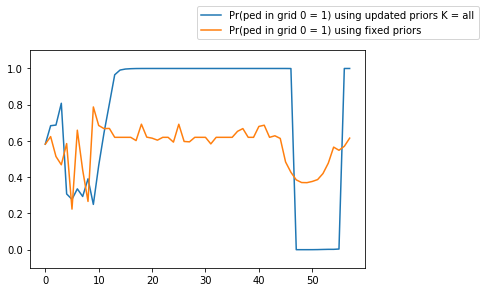

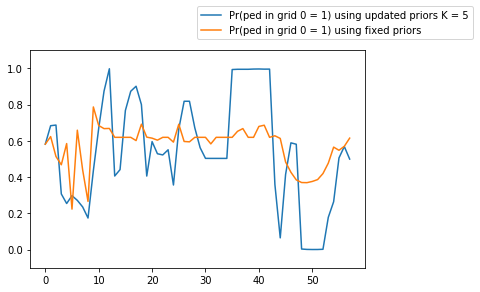

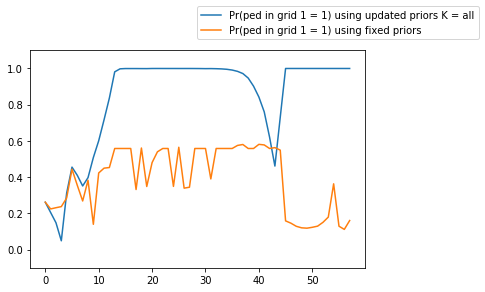

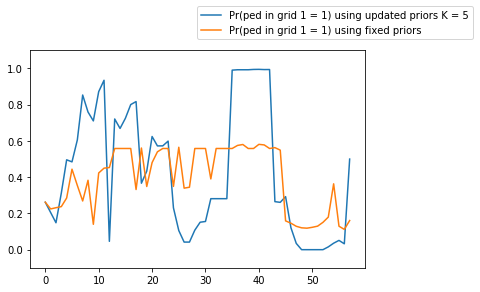

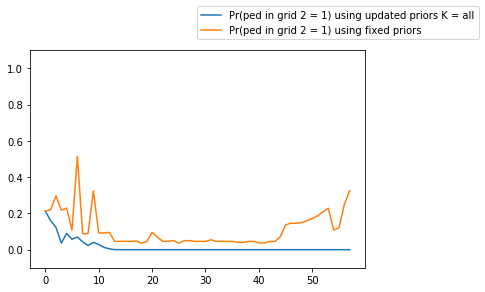

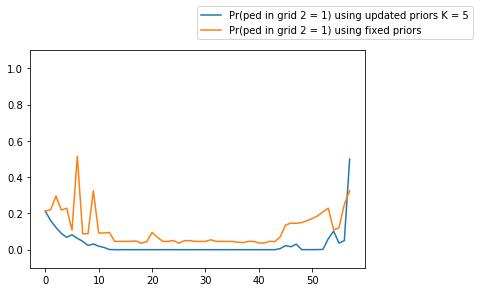

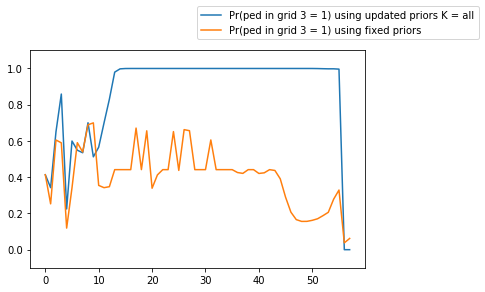

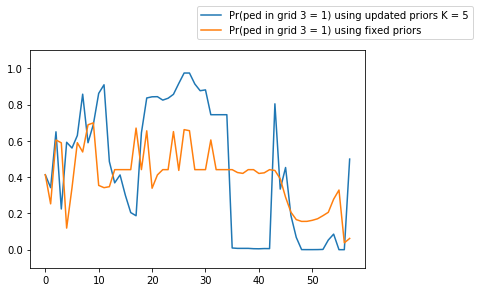

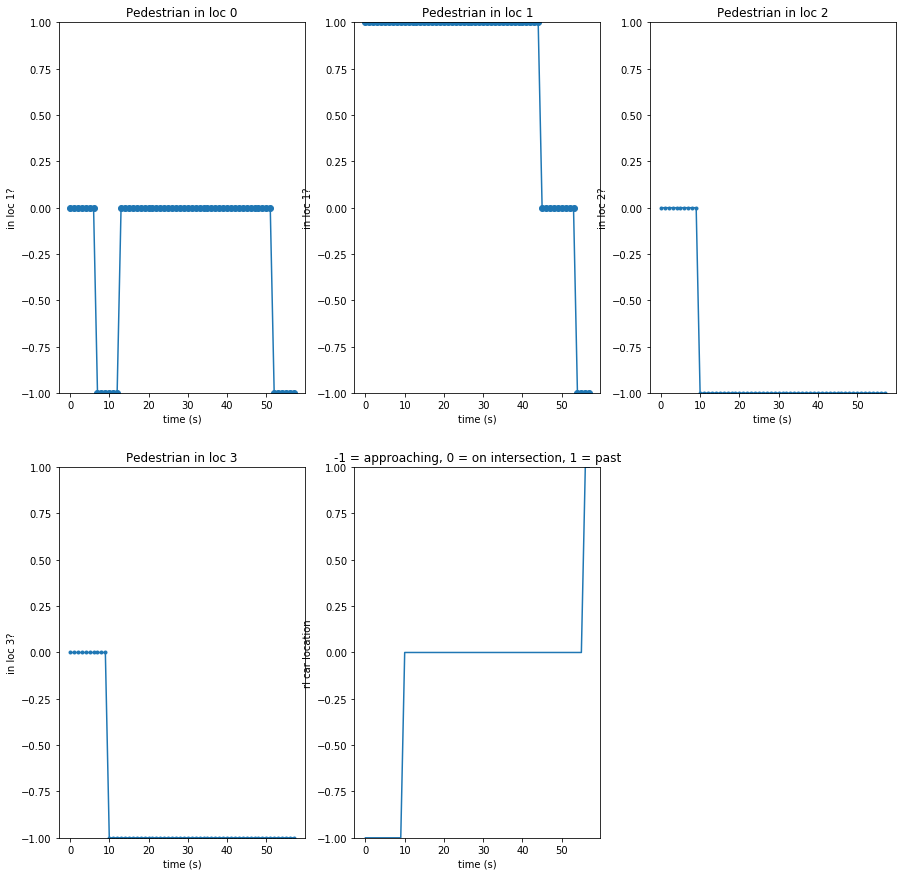

In [12]:
parser = create_parser()
args = parser.parse_args(["/home/thankyou-always/ray_results/bayesian_0_no_grid_env/PPO_Bayesian0NoGridEnv-v0_36d822ac_2020-05-23_17-05-02klp72ow9", "800"])
args = parser.parse_args(["/home/thankyou-always/TODO/research/bayesian_reasoning_traffic/shaped_97", "570"])
ray.shutdown()
ray.init(num_cpus=1)
run_transfer(args)